# Bike Rental Demand Prediction
### Group 3 -  Sahithi Nallani, Srivatsav Busi
**Data Source:** UCI Machine Learning Repository: [Seoul Bike Sharing Demand Data Set](https://archive.ics.uci.edu/ml/machine-learning-databases/00560/SeoulBikeData.csv)

Bike-sharing systems have revolutionized the traditional concept of bike rentals, making the whole process of membership, rental, and return completely automated. With these systems, users can easily rent a bike from one location and return it to another. Currently, there are over 2,000 bike-rental programs worldwide, comprising more than 2 million bicycles. Bike-rental systems have become increasingly popular due to their crucial role in addressing traffic, environmental, and health issues.
One of the primary challenges faced by bike-sharing systems is accurately estimating the number of bicycles needed to meet demand at any given time.
This is due to the many factors that can influence demand, such as weather, time of day, day of the week, and special events. Machine learning models can be trained on historical bike rental data to identify patterns and make predictions about future demand. By accurately predicting bike rental counts, bike-sharing companies and urban planners can make more informed decisions and improve the overall usability and sustainability of bike-sharing systems.

This dataset contains the hourly and daily count of rental bikes between years 2011 and 2012 in Capital bikeshare system with the corresponding weather and seasonal information.

The below code uses the "wget" shell command to download the "SeoulBikeData.csv" file from the UCI Machine Learning Repository. The CSV file contains data on bike sharing usage in Seoul, which can be used for machine learning and data analysis tasks.

In [1]:
%sh
wget https://archive.ics.uci.edu/ml/machine-learning-databases/00560/SeoulBikeData.csv


SyntaxError: invalid syntax (2569651088.py, line 2)

In [2]:
import requests

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00560/SeoulBikeData.csv"
response = requests.get(url)

if response.status_code == 200:
    with open("SeoulBikeData.csv", "wb") as file:
        file.write(response.content)
    print("File downloaded successfully.")
else:
    print("Failed to download the file.")


File downloaded successfully.


In [ ]:
pip install pyspark


Importing necessary libraries for data analysis and machine learning using Spark such pandas, numpy, matplotlib. Defining Spark functions and classes to perform regression modeling tasks, such as linear regression.

In [5]:
#Common Libraries
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#Spark Libraries
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType, FloatType, DateType, TimestampType, LongType, StringType
from pyspark.ml.feature import VectorAssembler,RFormula
from pyspark.ml.regression import LinearRegression, GeneralizedLinearRegression, DecisionTreeRegressor, GBTRegressor, RandomForestRegressor
from pyspark.ml import Pipeline, Model
from pyspark.ml.evaluation import RegressionEvaluator 
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import os
os.environ['PYSPARK_PIN_THREAD'] = 'true'


Reading the "SeoulBikeData.csv" file from the local filesystem using the Spark "read.csv" method, and load the data into a Spark DataFrame named df. The "cache()" method is called to cache it in memory for faster subsequent access.

In [8]:
# Read a CSV file into a Spark DataFrame
df = spark.read.csv("C:/Users/sahit/OneDrive/Documents/BDI/SeoulBikeData.csv", header="true", inferSchema="true")
df.cache()

DataFrame[Date: string, Rented Bike Count: int, Hour: int, Temperature(�C): double, Humidity(%): int, Wind speed (m/s): double, Visibility (10m): int, Dew point temperature(�C): double, Solar Radiation (MJ/m2): double, Rainfall(mm): double, Snowfall (cm): double, Seasons: string, Holiday: string, Functioning Day: string]

##Data Exploration

In [9]:
#Number of Records
print(f"Number of records: {df.count()}")
#Number of Columns
print(f"\nNumber of columns: {len(df.columns)}")

Number of records: 8760

Number of columns: 14


The dataframe consists of 8760 Records & 14 Attributes.
Let's display the data frame and analyse the fields in the input file.

In [10]:
df.show(10)
df.printSchema()

+----------+-----------------+----+---------------+-----------+----------------+----------------+-------------------------+-----------------------+------------+-------------+-------+----------+---------------+
|      Date|Rented Bike Count|Hour|Temperature(�C)|Humidity(%)|Wind speed (m/s)|Visibility (10m)|Dew point temperature(�C)|Solar Radiation (MJ/m2)|Rainfall(mm)|Snowfall (cm)|Seasons|   Holiday|Functioning Day|
+----------+-----------------+----+---------------+-----------+----------------+----------------+-------------------------+-----------------------+------------+-------------+-------+----------+---------------+
|01/12/2017|              254|   0|           -5.2|         37|             2.2|            2000|                    -17.6|                    0.0|         0.0|          0.0| Winter|No Holiday|            Yes|
|01/12/2017|              204|   1|           -5.5|         38|             0.8|            2000|                    -17.6|                    0.0|         0.0|

### Explanation of Data columns

- **Date** : The date of the rental, in the format of year-month-day.
- **Rented Bike count** :  The number of bikes rented during the given hour.
- **Hour** :  The hour of the day, ranging from 0 to 23.
- **Temperature**: The temperature in Celsius at the time of rental.
- **Humidity**: The relative humidity at the time of rental.
- **Windspeed** : The wind speed in meters per second at the time of rental.
- **Visibility** :  The visibility in meters at the time of rental.
- **Dew point temperature**: The dew point temperature in Celsius at the time of rental.
- **Solar radiation** : The solar radiation in Joule per square meter at the time of rental.
- **Rainfall** :  The rainfall in millimeters during the past hour at the time of rental.
- **Snowfall** :  The snowfall in centimeters during the past hour at the time of rental.
- **Seasons** :  The season of the year, classified into winter, spring, summer, and fall.
- **Holiday**:   Whether or not the day was a holiday in South Korea
- **Functional Day** :  Whether or not the hours are functional . 0(Non Functional Hours), 1(Functional hours)

Our target field is **"Rented Bike count"** which represents the count of total rental bikes demand per hour.<br/>


Our Target field is **"Rented Bike Count"** which represents the count of total rental bikes demand per hour.<br/>
Key predictor fields include "Temperature", "Humidity", "Visibility(10m)", "Seasons", "Functioning Day", "Holiday" etc. There is a combination of both numerical and categorical fields.

In [11]:
summary_stats = df[['Rented Bike Count', 'Temperature(�C)', 'Humidity(%)', 'Wind speed (m/s)',
                      'Visibility (10m)', 'Dew point temperature(�C)', 'Solar Radiation (MJ/m2)',
                      'Rainfall(mm)', 'Snowfall (cm)']].describe()
from pyspark.sql.functions import *

# Compute summary statistics using describe() function
stats_df =summary_stats.describe("Rented Bike Count", "Temperature(�C)", "Humidity(%)", "Wind speed (m/s)", "Visibility (10m)", "Dew point temperature(�C)", "Solar Radiation (MJ/m2)", "Rainfall(mm)", "Snowfall (cm)").show()

display(stats_df)


+-------+------------------+------------------+------------------+------------------+------------------+-------------------------+-----------------------+------------------+------------------+
|summary| Rented Bike Count|   Temperature(�C)|       Humidity(%)|  Wind speed (m/s)|  Visibility (10m)|Dew point temperature(�C)|Solar Radiation (MJ/m2)|      Rainfall(mm)|     Snowfall (cm)|
+-------+------------------+------------------+------------------+------------------+------------------+-------------------------+-----------------------+------------------+------------------+
|  count|                 5|                 5|                 5|                 5|                 5|                        5|                      5|                 5|                 5|
|   mean|2733.1199045067474|1761.2855495208914|1787.3177338018656|  1754.03224173384|2566.4249022141557|       1754.7468364247075|     1752.9915713945666|1759.2553760366688| 1753.862362934855|
| stddev|3638.1829162012937|3912.45

None

Performing categorical encoding using the "StringIndexer" method to the text values of columns("Seasons", "Holiday", and "Functioning Day") into numerical values.
The "fit" method is called on the indexer object to fit the encoding model to the DataFrame, and the resulting transformed DataFrame is stored in the "indexed_df" variable. The original categorical columns are then dropped from the DataFrame and the resulting DataFrame is displayed.

In [12]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.sql.functions import col
from pyspark.sql.functions import month
inputCols=["Seasons","Holiday","Functioning Day"]
outputCols=["Seasons_index","Holiday_index","Functioning Day_index"]

#Create a StringIndexer to convert the text columns into numerical values
indexer = StringIndexer(inputCols=inputCols, outputCols=outputCols)

#Fit the StringIndexer on the dataframe
indexed_df = indexer.fit(df).transform(df)



From the summary, we can see that there are 5 data points for each of the variables: Rented Bike Count, Temperature, Humidity, Wind speed, Visibility, Dew point temperature, Solar Radiation, Rainfall, and Snowfall. 
On average, 2733.12 bikes were rented during the period, meaning the temperature data points are highly spread out around the mean value of 1761.29

Renaming specific columns from a Spark DataFrame using the "withColumnRenamed" method. The for loop iterates over all columns in the DataFrame and replaces any spaces in their names with underscores. This results in a DataFrame with more readable and consistent column names, which is important for subsequent data analysis tasks.

In [13]:
df = indexed_df.drop("Seasons").drop("Holiday").drop("Functioning Day")
df = df.withColumnRenamed('Temperature(�C)', 'Temp')
df = df.withColumnRenamed('Humidity(%)', 'Humidity')
df = df.withColumnRenamed('Wind speed (m/s)', 'Wind_speed')
df = df.withColumnRenamed('Visibility (10m)', 'Visibility')
df = df.withColumnRenamed('Dew point temperature(�C)', 'Dew_point_temperature')
df = df.withColumnRenamed('Solar Radiation (MJ/m2)', 'Solar_Radiation')
df = df.withColumnRenamed('Rainfall(mm)', 'Rainfall')
df = df.withColumnRenamed('Snowfall (cm)', 'Snowfall')

for col in df.columns:  # Get rid of space in column name (causes trouble)
    df = df.withColumnRenamed(col,col.replace(" ", "_"))


#display(df)
df_with_month= df.withColumn("Month", month(df["date"]))
df_with_month.show(10)

+----------+-----------------+----+----+--------+----------+----------+---------------------+---------------+--------+--------+-------------+-------------+---------------------+-----+
|      Date|Rented_Bike_Count|Hour|Temp|Humidity|Wind_speed|Visibility|Dew_point_temperature|Solar_Radiation|Rainfall|Snowfall|Seasons_index|Holiday_index|Functioning_Day_index|Month|
+----------+-----------------+----+----+--------+----------+----------+---------------------+---------------+--------+--------+-------------+-------------+---------------------+-----+
|01/12/2017|              254|   0|-5.2|      37|       2.2|      2000|                -17.6|            0.0|     0.0|     0.0|          3.0|          0.0|                  0.0| NULL|
|01/12/2017|              204|   1|-5.5|      38|       0.8|      2000|                -17.6|            0.0|     0.0|     0.0|          3.0|          0.0|                  0.0| NULL|
|01/12/2017|              173|   2|-6.0|      39|       1.0|      2000|         

Creating a correlation matrix plot using the Python libraries matplotlib and seaborn. The plot can be used to identify any strong positive or negative correlations between variables, which can be useful in identifying multicollinearity. From the below Heat Map we can observe that the "Dew point temperature" and the "Temperature" colums have a very high collinearity.

<AxesSubplot:>

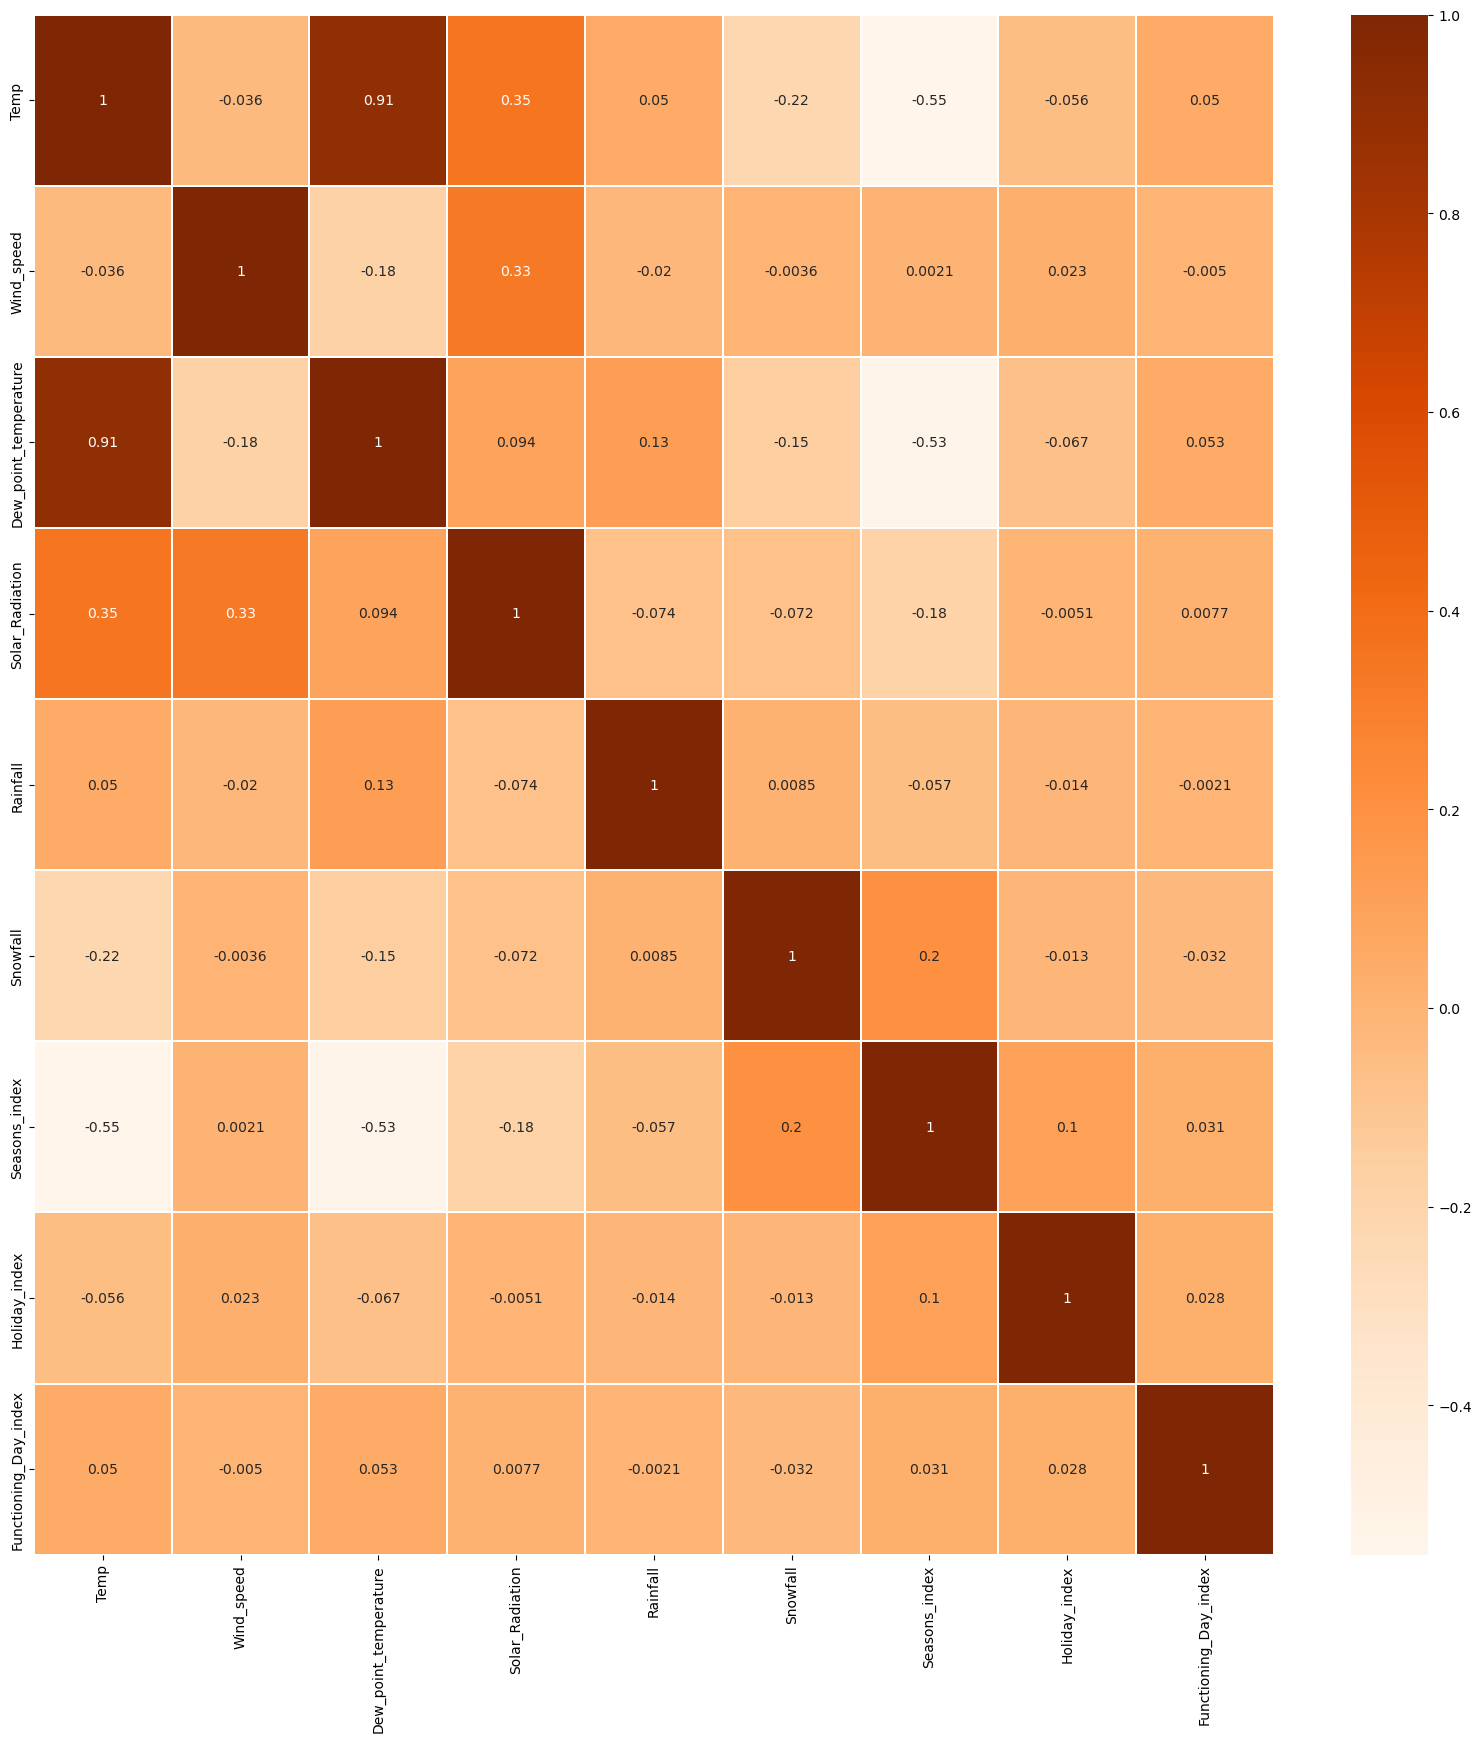

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
#creation of DataFrame
pd_df = df.toPandas()
# Drop non-numeric columns
numeric_df = pd_df.select_dtypes(include=['float64', 'int64'])  # Select only numeric columns

# Compute correlation matrix on the numeric DataFrame
Corr_Mat = numeric_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(20, 20))
sns.heatmap(Corr_Mat, annot=True, linewidth=0.1, cmap='Oranges')


Dropping the "Dew point temperature" column because it has very high colleniarity with the "Temperature" column followed by dropping the "Date" column as it can make the model more complex and harder to interpret, especially as the "Date" column has many unique values.

In [17]:
df=df.drop("Dew_point_temperature").drop("Date")
df.show(10)

+-----------------+----+----+--------+----------+----------+---------------+--------+--------+-------------+-------------+---------------------+
|Rented_Bike_Count|Hour|Temp|Humidity|Wind_speed|Visibility|Solar_Radiation|Rainfall|Snowfall|Seasons_index|Holiday_index|Functioning_Day_index|
+-----------------+----+----+--------+----------+----------+---------------+--------+--------+-------------+-------------+---------------------+
|              254|   0|-5.2|      37|       2.2|      2000|            0.0|     0.0|     0.0|          3.0|          0.0|                  0.0|
|              204|   1|-5.5|      38|       0.8|      2000|            0.0|     0.0|     0.0|          3.0|          0.0|                  0.0|
|              173|   2|-6.0|      39|       1.0|      2000|            0.0|     0.0|     0.0|          3.0|          0.0|                  0.0|
|              107|   3|-6.2|      40|       0.9|      2000|            0.0|     0.0|     0.0|          3.0|          0.0|        

In [19]:
df.select("Hour", "Rented_Bike_Count").show(24)

+----+-----------------+
|Hour|Rented_Bike_Count|
+----+-----------------+
|   0|              254|
|   1|              204|
|   2|              173|
|   3|              107|
|   4|               78|
|   5|              100|
|   6|              181|
|   7|              460|
|   8|              930|
|   9|              490|
|  10|              339|
|  11|              360|
|  12|              449|
|  13|              451|
|  14|              447|
|  15|              463|
|  16|              484|
|  17|              555|
|  18|              862|
|  19|              600|
|  20|              426|
|  21|              405|
|  22|              398|
|  23|              323|
+----+-----------------+
only showing top 24 rows



The line plot shows that bike rentals peak during the hours of 10 pm to 2 am, this suggests that there is a high demand for bike rentals during those hours. Seoul is known for its bustling nightlife, people could be renting bikes to travel between restaurants during these hours, as it may be faster and more convenient than using other forms of transportation, especially if the traffic is heavy.

In [20]:
df.select("Holiday_index", "Rented_Bike_Count").show(10)

+-------------+-----------------+
|Holiday_index|Rented_Bike_Count|
+-------------+-----------------+
|          0.0|              254|
|          0.0|              204|
|          0.0|              173|
|          0.0|              107|
|          0.0|               78|
|          0.0|              100|
|          0.0|              181|
|          0.0|              460|
|          0.0|              930|
|          0.0|              490|
+-------------+-----------------+
only showing top 10 rows



## Tableau Visulization
[Tableau Dashboard Link](https://public.tableau.com/views/M2Group19/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link)
<div class='tableauPlaceholder' id='viz1682818592605' style='position: relative'><noscript><a href='#'><img alt='Dashboard 1 ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;M2&#47;M2Group19&#47;Dashboard1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='M2Group19&#47;Dashboard1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;M2&#47;M2Group19&#47;Dashboard1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en-US' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1682818592605');                    var vizElement = divElement.getElementsByTagName('object')[0];                    if ( divElement.offsetWidth > 800 ) { vizElement.style.width='1000px';vizElement.style.height='2027px';} else if ( divElement.offsetWidth > 500 ) { vizElement.style.width='1000px';vizElement.style.height='2027px';} else { vizElement.style.width='100%';vizElement.style.height='1577px';}                     var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

The area plot shows that bike rentals peak during the holiday season, this suggests that there is a high demand for bike rentals on holidays be it a weekend or a public holiday. Seoul is a bustling city with a lot of outdoor spaces that are perfect for biking.On holidays, people in Seoul often take advantage of the good weather and head out to one of the many bike paths and trails in the city.

### Data Split
Spliting the Spark DataFrame "df" into a training set and a test set, with **65%** of the data in the training set and **35%** in the test set. 


In [21]:
train, test = df.randomSplit([0.65, 0.35], seed = 1)
print("There are %d training examples and %d test examples." % (train.count(), test.count()))

There are 5732 training examples and 3028 test examples.


The line plot shows that bike rentals peak during the hours of 10 pm to 2 am, this suggests that there is a high demand for bike rentals during those hours. Seoul is known for its bustling nightlife, people could be renting bikes to travel between restaurants during these hours, as it may be faster and more convenient than using other forms of transportation, especially if the traffic is heavy.

### Pipeline & Transformations (Using RFormula)

Creating a list containing the column names of the dataframe and remove 'Rented_Bike_Count' from the list columns.
RFormula implements the transforms required for fitting a dataset against an R model formula. 
A new Pipeline object is created and assigned to the variable pipeline, with an empty list specified as the stages argument.
basePipeline list will be used to store the stages of the pipeline and will be used as the starting point.

In [22]:
columns = df.columns
columns.remove('Rented_Bike_Count')
# with RFormula
formula = "{} ~ {}".format("Rented_Bike_Count", " + ".join(columns))
print("Formula : {}".format(formula))
rformula = RFormula(formula = formula)

# Pipeline basic to be shared across model fitting and testing
pipeline = Pipeline(stages=[])  # Must initialize with empty list!

# base pipeline (the processing here should be reused across pipelines)
basePipeline =[rformula]

Formula : Rented_Bike_Count ~ Hour + Temp + Humidity + Wind_speed + Visibility + Solar_Radiation + Rainfall + Snowfall + Seasons_index + Holiday_index + Functioning_Day_index


In [23]:
from pyspark.ml.regression import LinearRegression
 
lr = LinearRegression(labelCol="Rented_Bike_Count")

In [24]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

paramGrid = ParamGridBuilder()\
  .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .addGrid(lr.maxIter, [10, 20]) \
  .build()
 
# Define two metrics for regression
rmse = RegressionEvaluator(metricName="rmse", labelCol=lr.getLabelCol(), predictionCol=lr.getPredictionCol())
r2 = RegressionEvaluator(metricName="r2", labelCol=lr.getLabelCol(), predictionCol=lr.getPredictionCol())
 
cv = CrossValidator(estimator=lr, evaluator=r2, estimatorParamMaps=paramGrid)

In [25]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[rformula, cv])

In [26]:
pipelineModel = pipeline.fit(train)

In [27]:
lm = pipelineModel.stages[1].bestModel

##Summaries

### Training Summary

In [28]:
lm.summary
lm.summary.r2

0.5301666595001244

Training Summary: Model coefficient, intercept (like R)

In [29]:
import pyspark.sql.functions as F

x_cols = columns

# Nice summary here: https://www.learnbymarketing.com/tutorials/explaining-the-lm-summary-in-r
def f_stats(residuals, num_coefficients):
  sse = residuals.withColumn('res_sq', residuals.residual * residuals.residual).agg(F.sum('res_sq').alias('SSE')).collect()[0]['SSE']
  y_mean = residuals.agg(F.mean('prediction').alias('y_mean')).collect()[0]['y_mean']
  SSyy = residuals.withColumn('mean_diff', (residuals.prediction - y_mean) * (residuals.prediction - y_mean)).agg(F.sum('mean_diff').alias('SSyy')).collect()[0]['SSyy']
  n = residuals.count()
  res_std_err = (sse / (n - (num_coefficients+1)))
  f_stat = ((SSyy - sse) / num_coefficients) / (sse / (n - (num_coefficients+1)))
  return res_std_err, f_stat

def residuals_summary(lm, data):
  lm_results = pipelineModel.transform(data)
  labeled_predictions = lm_results.select(lm.summary.labelCol, lm.summary.predictionCol)
  residuals = labeled_predictions.withColumn('residual', labeled_predictions[lm.summary.labelCol] - labeled_predictions[lm.summary.predictionCol])
  res_summary = residuals.summary().select('residual')
  res_vals = [res_summary.collect()[3]['residual'], res_summary.collect()[4]['residual'], res_summary.collect()[5]['residual'], res_summary.collect()[6]['residual'], res_summary.collect()[7]['residual']]
  res_labels = ['Min', '1Q', 'Median', '3Q', 'Max']
  print("Rediduals:")
  print(''.join([f"{l:>15}" for l in res_labels]))
  print(''.join([f"{float(l):>15,.3f}" for l in res_vals]))
  return residuals

def lm_summary(lm, formula, columns, lm_summary=None, data=None):
  """
  Print a regression summary similar to that provided by R.
  """  
  if not lm_summary:
    lm_summary = lm.summary  
  try:
    coefficients, coefficientStandardErrors, tValues, pValues = lm.coefficients, lm_summary.coefficientStandardErrors, lm_summary.tValues, lm_summary.pValues
  except Exception:    
    coefficients, coefficientStandardErrors, tValues, pValues = [0.0] * len(columns), [0.0] * len(columns), [0.0] * len(columns), [0.0] * len(columns)
  if data:
    residuals = residuals_summary(lm, data)
    
  equation = ' + '.join([f"{p[0]:,.1f} * {p[1]:<12.12}" for p in zip(coefficients, columns)]) + f"+ {lm.intercept:,.1f}"
  print(f"Formula\n\t{formula}")
  print(f"Equation\n\t{equation}")
  print("Coefficients:")
  print(f"{'': <25.25} {'Estimate': ^25.25} {'Std.Error': ^20} {'t value': ^20} {'Pr(>|t|': ^20}")
  print(f"{'(Intercept)': <25.25} {lm.intercept: >20,.3f}")
  values = zip(columns, coefficients, coefficientStandardErrors, tValues, pValues)
  for p in values:
    print(f"{p[0]: <25.25} {p[1]: >20,.3f} {p[2]: >20,.3f} {p[3]: >20,.3f} {p[4]: >20,.3f}")
  print(f"Root mean squared error (RMSE): {lm_summary.rootMeanSquaredError:,.3f} on {lm_summary.degreesOfFreedom:,} degrees of freedom")
  print(f"Multiple R-squared: {lm_summary.r2:.4f}, Adjusted R-squared: {lm_summary.r2adj:.4f}")
  if residuals:
    res_err, f_stat = f_stats(residuals, len(columns))
    print(f"Residual standard error: {res_err:,.2f}")
    print(f"F-statistic: {f_stat:,.2f}")
  return residuals
  
residuals = lm_summary(lm, formula, x_cols, data=train)

Rediduals:
            Min             1Q         Median             3Q            Max
     -1,267.357       -290.351        -47.044        213.287      2,252.307
Formula
	Rented_Bike_Count ~ Hour + Temp + Humidity + Wind_speed + Visibility + Solar_Radiation + Rainfall + Snowfall + Seasons_index + Holiday_index + Functioning_Day_index
Equation
	0.0 * Hour         + 0.0 * Temp         + 0.0 * Humidity     + 0.0 * Wind_speed   + 0.0 * Visibility   + 0.0 * Solar_Radiat + 0.0 * Rainfall     + 0.0 * Snowfall     + 0.0 * Seasons_inde + 0.0 * Holiday_inde + 0.0 * Functioning_+ 497.2
Coefficients:
                                  Estimate               Std.Error             t value              Pr(>|t|       
(Intercept)                            497.183
Hour                                     0.000                0.000                0.000                0.000
Temp                                     0.000                0.000                0.000                0.000
Humidity             

Apply the model to the training data

In [30]:
lm_results = pipelineModel.transform(train)
labeled_predictions = lm_results.select('Rented_Bike_Count', 'prediction')

comp = labeled_predictions.toPandas()

Actual vs predicted (training data)

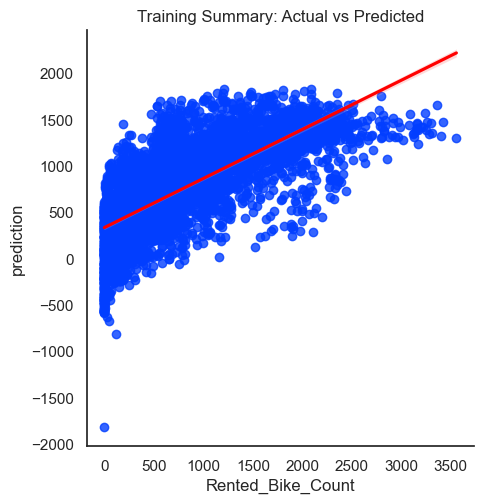

In [31]:
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')
sns.set_palette("bright")

sns.lmplot(data=comp, x="Rented_Bike_Count", y="prediction", line_kws={'color': 'red'}, height=5, aspect=1).set(title='Training Summary: Actual vs Predicted');

Actual vs residuals

C:\Users\sahit\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\sahit\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


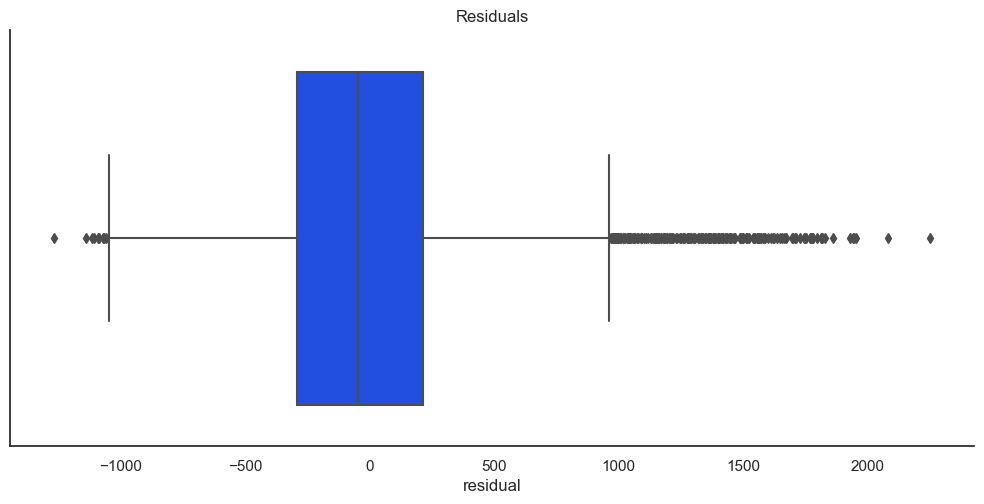

In [32]:
sns.catplot(data=residuals.toPandas(), x='residual', kind='box',  height=5, aspect=2).set(title='Residuals');

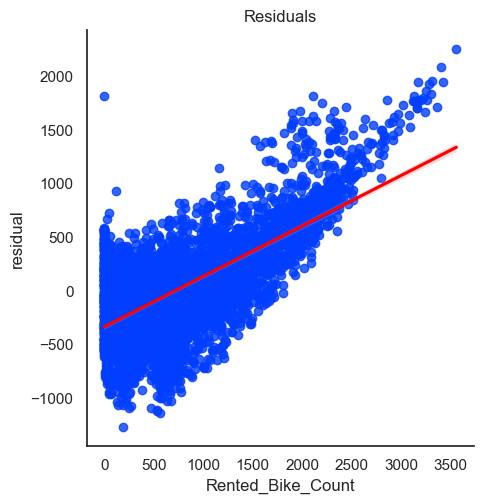

In [33]:
sns.lmplot(data=residuals.toPandas(), x=lm.summary.labelCol, y='residual', line_kws={'color': 'red'}, height=5, aspect=1).set(title='Residuals');

# Training vs Testing
* During training, a model is created and evaluated using the training data. This trained model can then be used to make predictions on test data.
* However, the model's performance on the test data may differ from its performance on the training data.

## Prediction Summary

Trained model applied to test data

In [34]:
lm_results = pipelineModel.transform(test)
labeled_predictions = lm_results.select('Rented_Bike_Count', 'prediction')

comp = labeled_predictions.toPandas()

In [35]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Rented_Bike_Count")
rmse = evaluator.evaluate(labeled_predictions, {evaluator.metricName: "rmse"})
print(f"Test root mean squared error (RMSE) {rmse:,.4f}")
r2 = evaluator.evaluate(labeled_predictions, {evaluator.metricName: "r2"})
print(f"Test multiple R-squared r2: {r2:,.4f}")
mae = evaluator.evaluate(labeled_predictions, {evaluator.metricName: "mae"})
print(f"Test mean absolute error (MAE): {mae:,.4f}")

Test root mean squared error (RMSE) 441.3723
Test multiple R-squared r2: 0.5153
Test mean absolute error (MAE): 332.5310


In [36]:
predictions = pipelineModel.transform(test)

Linear regression model has a R2 value of 0.52 i.e 52% close to predicting the actual flight price.

In [37]:
predictions.select("Rented_Bike_Count", "prediction").show(15)

+-----------------+-------------------+
|Rented_Bike_Count|         prediction|
+-----------------+-------------------+
|                0|-426.64109962604084|
|                0|-424.15434493505563|
|                0| -488.3816329708151|
|                0| -573.9674076833859|
|                0|  -593.149402522081|
|                0| -464.6073872930723|
|                0| -427.9649086446211|
|                0|-505.14625820452477|
|                0|   -322.69673320534|
|                0|-353.24530832133064|
|                0| -462.4186528446402|
|                0|  -519.262823862222|
|                0| -521.2270069481336|
|                0| -497.6267904869304|
|                0| -438.3227557869508|
+-----------------+-------------------+
only showing top 15 rows



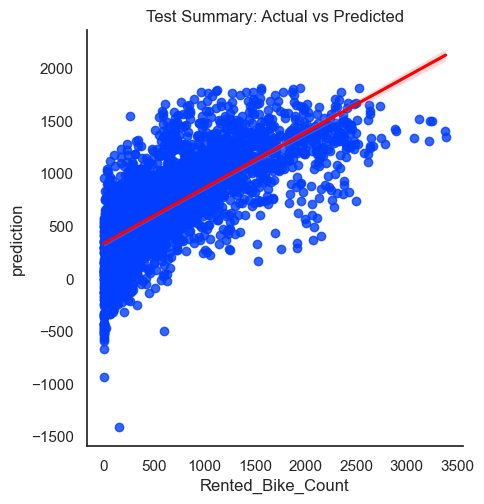

In [38]:
# From Spark to Pandas
comp = predictions.toPandas()

import seaborn as sns
import matplotlib.pyplot as plt 
sns.set_context('notebook')
sns.set_style('white')
sns.set_palette("bright")


sns.lmplot(data=comp, x='Rented_Bike_Count', y='prediction', line_kws={'color': 'red'}, height=5, aspect=1).set(title='Test Summary: Actual vs Predicted');

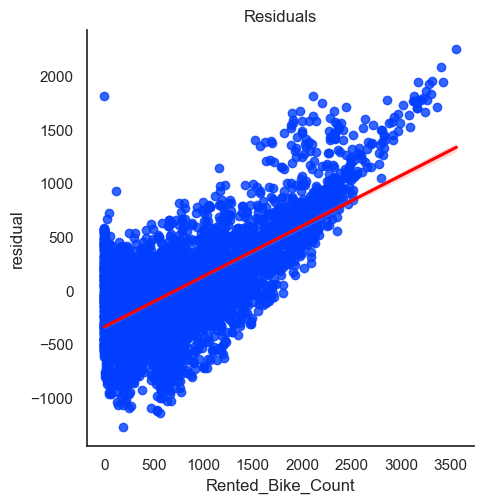

In [39]:
sns.lmplot(data=residuals.toPandas(), x=lm.summary.labelCol, y='residual', line_kws={'color': 'red'}, height=5, aspect=1).set(title='Residuals');

# Regression summary from test data
* Test data is transformed with pipeline prior to Linear Regression
* Apply trained Linear Regression model to transformed test data
* Print Linear Regression summary
  * Empty values for model
  * See summary above for model coefficients (which have not changed with test data)

Prepare test data for input to regression model

In [40]:
rff = rformula.fit(test)
td = rff.transform(test)

Regression summary of trained model applied to test data

In [41]:
lm_eval = lm.evaluate(td)
lm_eval

Testing Summary: model from training data applied to test data

In [42]:
residuals = lm_summary(lm, formula, x_cols, lm_summary=lm_eval, data=test);

Rediduals:
            Min             1Q         Median             3Q            Max
     -1,287.821       -299.919        -59.085        203.797      2,042.164
Formula
	Rented_Bike_Count ~ Hour + Temp + Humidity + Wind_speed + Visibility + Solar_Radiation + Rainfall + Snowfall + Seasons_index + Holiday_index + Functioning_Day_index
Equation
	0.0 * Hour         + 0.0 * Temp         + 0.0 * Humidity     + 0.0 * Wind_speed   + 0.0 * Visibility   + 0.0 * Solar_Radiat + 0.0 * Rainfall     + 0.0 * Snowfall     + 0.0 * Seasons_inde + 0.0 * Holiday_inde + 0.0 * Functioning_+ 497.2
Coefficients:
                                  Estimate               Std.Error             t value              Pr(>|t|       
(Intercept)                            497.183
Hour                                     0.000                0.000                0.000                0.000
Temp                                     0.000                0.000                0.000                0.000
Humidity             

# Decision Tree Regressor

In [43]:
from pyspark.ml.regression import DecisionTreeRegressor
 
dt = DecisionTreeRegressor(labelCol="Rented_Bike_Count")

In [44]:
from pyspark.ml.evaluation import RegressionEvaluator

DecisionTree_paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [2, 5, 10]) \
    .addGrid(dt.maxBins, [32, 64, 128]) \
    .build()

dt_rmse = RegressionEvaluator(metricName="rmse", labelCol=dt.getLabelCol(), predictionCol=dt.getPredictionCol())
dt_r2 = RegressionEvaluator(metricName="r2", labelCol=dt.getLabelCol(), predictionCol=dt.getPredictionCol())
 
dt_cv = CrossValidator(estimator=dt, evaluator=dt_rmse, estimatorParamMaps=DecisionTree_paramGrid)

In [45]:
from pyspark.ml import Pipeline
dt_pipeline = Pipeline(stages=[rformula, dt_cv])

In [46]:
dt_pipelineModel = dt_pipeline.fit(train)

In [47]:
dt_bestmodel = dt_pipelineModel.stages[1].bestModel

In [48]:
dt_pipelineModel.stages[1].bestModel.toDebugString

'DecisionTreeRegressionModel: uid=DecisionTreeRegressor_87f3b2506b9f, depth=10, numNodes=1093, numFeatures=11\n  If (feature 1 <= 11.25)\n   If (feature 8 in {0.0,3.0})\n    If (feature 0 <= 6.5)\n     If (feature 0 <= 1.5)\n      If (feature 1 <= 7.35)\n       If (feature 1 <= 1.15)\n        If (feature 3 <= 1.05)\n         If (feature 1 <= -4.15)\n          If (feature 7 <= 0.05)\n           If (feature 1 <= -9.149999999999999)\n            Predict: 108.33333333333333\n           Else (feature 1 > -9.149999999999999)\n            Predict: 165.0\n          Else (feature 7 > 0.05)\n           If (feature 0 <= 0.5)\n            Predict: 61.0\n           Else (feature 0 > 0.5)\n            Predict: 94.0\n         Else (feature 1 > -4.15)\n          If (feature 7 <= 0.8500000000000001)\n           If (feature 3 <= 0.25)\n            Predict: 138.33333333333334\n           Else (feature 3 > 0.25)\n            Predict: 220.1304347826087\n          Else (feature 7 > 0.8500000000000001)\n    

# Summaries

Apply the model to the training data

In [49]:
dt_results = dt_pipelineModel.transform(train)
labeled_predictions = dt_results.select('Rented_Bike_Count', 'prediction')

comp = labeled_predictions.toPandas()

Actual vs predicted (training data)

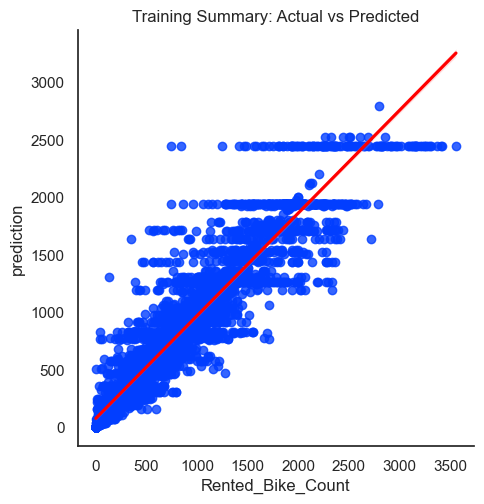

In [50]:
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')
sns.set_palette("bright")

sns.lmplot(data=comp, x='Rented_Bike_Count', y='prediction', line_kws={'color': 'red'}, height=5, aspect=1).set(title='Training Summary: Actual vs Predicted');

* After being trained on a dataset, a model is created and evaluated against that same dataset. 
* However, when the model is applied to a new set of data for predictions, it may perform differently compared to its performance on the training dataset.

Trained model applied to test data

In [51]:
dt_results = dt_pipelineModel.transform(test)
labeled_predictions = dt_results.select('Rented_Bike_Count', 'prediction')

comp = labeled_predictions.toPandas()

Model fit with test data

In [52]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Rented_Bike_Count")
rmse = evaluator.evaluate(labeled_predictions, {evaluator.metricName: "rmse"})
print(f"Test root mean squared error (RMSE) {rmse:,.4f}")
r2 = evaluator.evaluate(labeled_predictions, {evaluator.metricName: "r2"})
print(f"Test multiple R-squared r2: {r2:,.4f}")
mae = evaluator.evaluate(labeled_predictions, {evaluator.metricName: "mae"})
print(f"Test mean absolute error (MAE): {mae:,.4f}")

Test root mean squared error (RMSE) 285.4176
Test multiple R-squared r2: 0.7973
Test mean absolute error (MAE): 173.0669


In [53]:
display(labeled_predictions.select("Rented_Bike_Count", "prediction"))

DataFrame[Rented_Bike_Count: int, prediction: double]

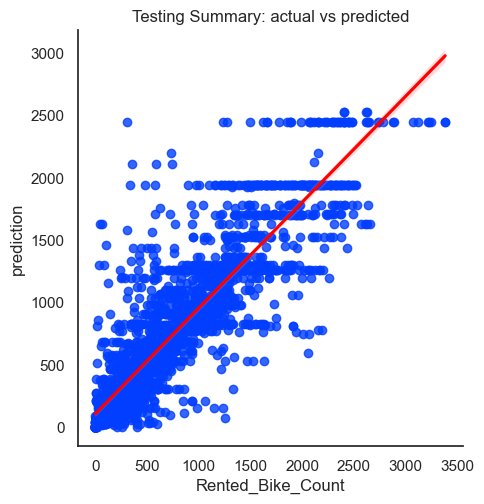

In [54]:
# From Spark to Pandas
#pdf = dt_predictions.toPandas()

import seaborn as sns
import matplotlib.pyplot as plt   #Data visualisation libraries 
sns.set_context('notebook')
sns.set_style('white')
sns.set_palette("bright")


sns.lmplot(data=comp, x='Rented_Bike_Count', y='prediction', line_kws={'color': 'red'}, height=5, aspect=1).set(title='Testing Summary: actual vs predicted');

#Random Forest model

In [55]:
from pyspark.ml.regression import RandomForestRegressor
 
rf = RandomForestRegressor(labelCol="Rented_Bike_Count")
from pyspark.ml.evaluation import RegressionEvaluator

RandomForest_paramGrid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [2, 5, 10]) \
    .addGrid(rf.numTrees, [10, 20, 50]) \
    .addGrid(rf.featureSubsetStrategy, ["auto", "sqrt", "log2"]) \
    .build()

rf_rmse = RegressionEvaluator(metricName="rmse", labelCol=rf.getLabelCol(), predictionCol=rf.getPredictionCol())
rf_r2 = RegressionEvaluator(metricName="r2", labelCol=rf.getLabelCol(), predictionCol=rf.getPredictionCol())
 
rf_cv = CrossValidator(estimator=rf, evaluator=rf_rmse, estimatorParamMaps=RandomForest_paramGrid)

from pyspark.ml import Pipeline
pipelinerf = Pipeline(stages=[rformula, rf_cv])

pipelineModelrf = pipelinerf.fit(train)

bestmodelrf = pipelineModelrf.stages[1].bestModel

pipelineModelrf.stages[1].bestModel.trees[1].toDebugString

predictionsrf = pipelineModelrf.transform(test)

resultsrf = pipelineModelrf.transform(train)
labeled_predictions = resultsrf.select('Rented_Bike_Count', 'prediction')

pdfrf = labeled_predictions.toPandas()

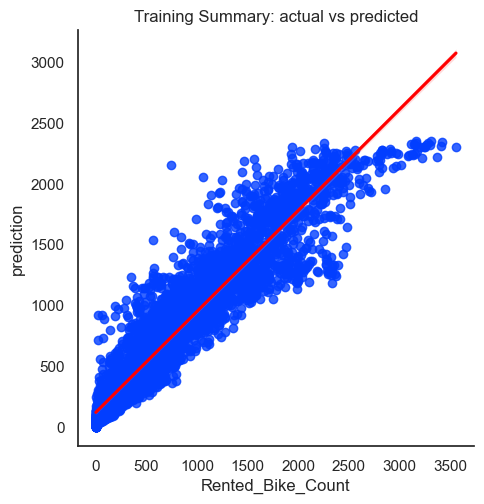

In [56]:
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')
sns.set_palette("bright")

sns.lmplot(data=pdfrf, x='Rented_Bike_Count', y='prediction', line_kws={'color': 'red'}, height=5, aspect=1).set(title='Training Summary: actual vs predicted');

Actual vs Predicted 

Test root mean squared error (RMSE) 258.2793
Test multiple R-squared r2: 0.8340
Test mean absolute error (MAE): 167.6130


DataFrame[Rented_Bike_Count: int, prediction: double]

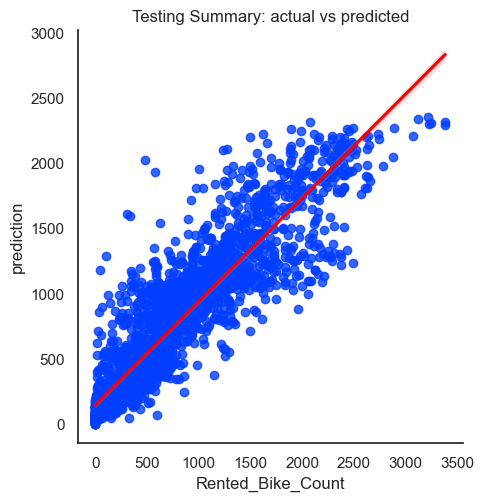

In [57]:
resultsrf = pipelineModelrf.transform(test)
labeled_predictions = resultsrf.select('Rented_Bike_Count', 'prediction')

pdf_rf = labeled_predictions.toPandas()

from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Rented_Bike_Count")
rmse = evaluator.evaluate(labeled_predictions, {evaluator.metricName: "rmse"})
print(f"Test root mean squared error (RMSE) {rmse:,.4f}")
r2 = evaluator.evaluate(labeled_predictions, {evaluator.metricName: "r2"})
print(f"Test multiple R-squared r2: {r2:,.4f}")
mae = evaluator.evaluate(labeled_predictions, {evaluator.metricName: "mae"})
print(f"Test mean absolute error (MAE): {mae:,.4f}")
display(labeled_predictions.select("Rented_Bike_Count", "prediction"))

# From Spark to Pandas
pdf = predictionsrf.toPandas()

import seaborn as sns
import matplotlib.pyplot as plt   #Data visualisation libraries 
sns.set_context('notebook')
sns.set_style('white')
sns.set_palette("bright")


sns.lmplot(data=pdf, x='Rented_Bike_Count', y='prediction', line_kws={'color': 'red'}, height=5, aspect=1).set(title='Testing Summary: actual vs predicted');

### Models & Parameter Grid

We are implementing 5 different regression models.
-   Linear Regression
-   Generalized Linear Model (GLM)
-   Random Forest Regressor
-   Decision Tree Regressor
-   Gradient-Boosted Tree Regressor (GBT)

The code defines a linear regression model, creates a pipeline by combining an RFormula stage and the linear regression stage, and creates a grid of hyperparameters to be tested during cross-validation.The process of creating pipelines and hyperparameter grids is repeated for four different regression models: Generalized Linear Regression, Random Forest Regressor, Decision Tree Regression, and GBTRegressor. For each model, a pipeline is created by combining an RFormula stage and the model stage, and a grid of hyperparameters is created to be searched over during cross-validation.

In [58]:
# Linear Regression model
linear_regression = LinearRegression()
linear_regression_pipeline = basePipeline + [linear_regression]
linear_regression_param_grid = ParamGridBuilder()\
          .baseOn({pipeline.stages: linear_regression_pipeline})\
          .addGrid(linear_regression.regParam, [0.01, 0.04])\
          .build()

In [59]:
# Random Forest model
random_forest = RandomForestRegressor()
random_forest_pipeline = basePipeline + [random_forest]
random_forest_param_grid = ParamGridBuilder()\
    .baseOn({pipeline.stages: random_forest_pipeline})\
    .addGrid(random_forest.maxDepth, [4, 6, 8])\
    .build()


In [60]:
# Decision Tree Regression model
decision_tree = DecisionTreeRegressor()
decision_tree_pipeline = basePipeline + [decision_tree]
decision_tree_param_grid = ParamGridBuilder()\
      .baseOn({pipeline.stages: decision_tree_pipeline})\
      .addGrid(decision_tree.maxDepth, [5, 8])\
      .build()

In [61]:
# Gradient Boosted Tree Regression model
gradient_boosted_tree = GBTRegressor()
gradient_boosted_tree_pipeline = basePipeline + [gradient_boosted_tree]
gradient_boosted_tree_param_grid = ParamGridBuilder()\
      .baseOn({pipeline.stages: gradient_boosted_tree_pipeline})\
      .addGrid(gradient_boosted_tree.maxDepth, [2, 6])\
      .addGrid(gradient_boosted_tree.maxIter, [10, 100])\
      .build()

The code combines the hyperparameter grids for the five regression models (Linear Regression, Generalized Linear Regression, Random Forest Regressor, Decision Tree Regression, and GBTRegressor) into a single list of parameter maps.
The resulting param list contains a dictionary of hyperparameters to be tested during cross-validation for each combination of model and hyperparameter.

In [62]:
# One grid from the individual grids
all_param_grids = linear_regression_param_grid + random_forest_param_grid + decision_tree_param_grid + gradient_boosted_tree_param_grid

### Cross Validator

Creating a crossValidator object, sets its estimator to be the pipeline created earlier, sets the evaluator to be a regression evaluator with the metric "r2", sets the estimator parameter maps to be the param list of hyperparameters, and sets the number of folds to 3 for cross-validation.

In [63]:

cross_validator = CrossValidator().setEstimator(pipeline)\
      .setEvaluator(RegressionEvaluator().setMetricName("r2"))\
      .setEstimatorParamMaps(all_param_grids).setNumFolds(3)

 

### Fitting Cross Validator on Train Data

In [64]:
cv_model = cross_validator.fit(train)
cv_model

CrossValidatorModel_868cff053498

### Best Model

In [65]:
# RegressionEvaluator metric name is r2, so higher is better
# http://gim.unmc.edu/dxtests/roc3.htm
print("Best Model")
print(cv_model.getEstimatorParamMaps()[ np.argmax(cv_model.avgMetrics) ])
print("")
print("Max R2 Score is: {}".format(np.max(cv_model.avgMetrics)))

Best Model
{Param(parent='Pipeline_3a612342bef1', name='stages', doc='a list of pipeline stages'): [RFormula_ed4d1ed7b9a2, GBTRegressor_0735ca950eb0], Param(parent='GBTRegressor_0735ca950eb0', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 6, Param(parent='GBTRegressor_0735ca950eb0', name='maxIter', doc='max number of iterations (>= 0).'): 100}

Max R2 Score is: 0.8344840663430252


### Worst Model

In [66]:
print("Worst Model")
print (cv_model.getEstimatorParamMaps()[ np.argmin(cv_model.avgMetrics) ])
print("")
print("Min R2 score is: {}".format(np.min(cv_model.avgMetrics)))

Worst Model
{Param(parent='Pipeline_3a612342bef1', name='stages', doc='a list of pipeline stages'): [RFormula_ed4d1ed7b9a2, LinearRegression_cfeb0583416a], Param(parent='LinearRegression_cfeb0583416a', name='regParam', doc='regularization parameter (>= 0).'): 0.01}

Min R2 score is: 0.52843634763846


In [67]:
num_models = len(cv_model.getEstimatorParamMaps())
print(f"Ran {num_models} models")
print(f"Average model metric over the folds are: {cv_model.avgMetrics}")

Ran 11 models
Average model metric over the folds are: [0.52843634763846, 0.5284364675095874, 0.659597734434236, 0.7572945840336976, 0.8125791906549878, 0.7175166769992752, 0.7810875655819212, 0.6625478454245074, 0.8206689107119282, 0.8157603287632972, 0.8344840663430252]


### Model Evaluations

In [68]:
import re
def paramGrid_model_name(model):
  params = [v for v in model.values() if type(v) is not list]
  name = [v[-1] for v in model.values() if type(v) is list][0]
  name = re.match(r'([a-zA-Z]*)', str(name)).groups()[0]
  return "{}{}".format(name,params)

# Resulting metric and model description
# get the measure from the CrossValidator, cvModel.avgMetrics
# get the model name & params from the paramGrid
# put them together here:
measures = zip(cv_model.avgMetrics, [paramGrid_model_name(m) for m in all_param_grids])
metrics,model_names = zip(*measures)

<Figure size 640x480 with 0 Axes>

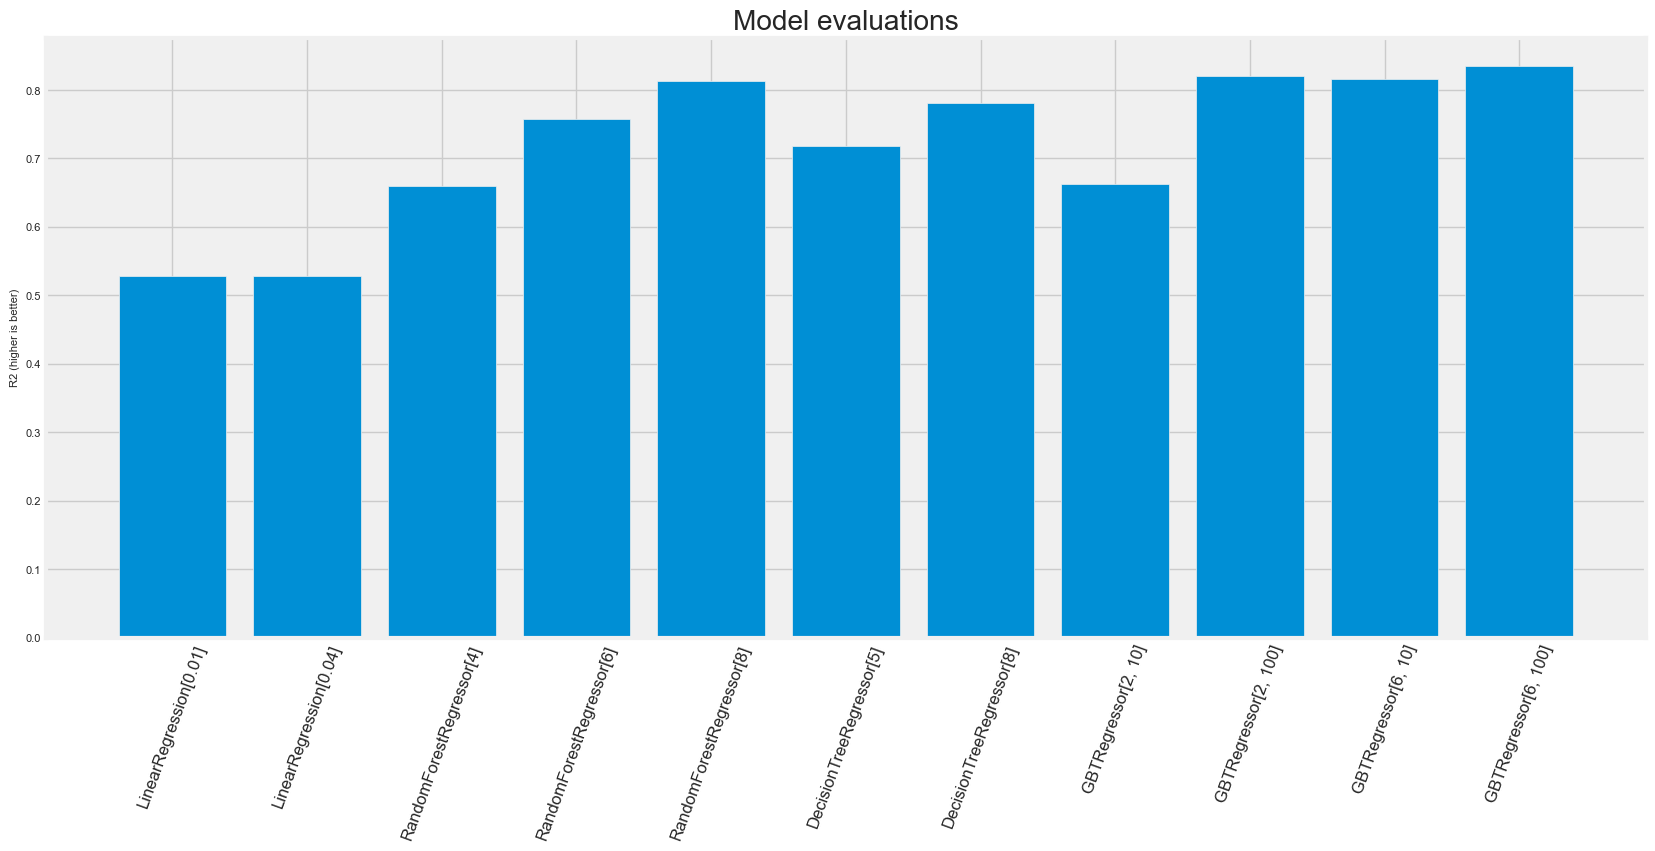

None

In [69]:
plt.clf() # clear figure
fig = plt.figure( figsize=(20, 10))
plt.style.use('fivethirtyeight')
axis = fig.add_axes([0.1, 0.3, 0.8, 0.6])
# plot the metrics as Y
#plt.plot(range(len(model_names)),metrics)
plt.bar(range(len(model_names)),metrics)
# plot the model name & param as X labels
plt.xticks(range(len(model_names)), model_names, rotation=70, fontsize=12)
plt.yticks(fontsize=8)
#plt.xlabel('model',fontsize=8)
plt.ylabel('R2 (higher is better)',fontsize=8)
plt.title('Model evaluations')
display(plt.show())

In [70]:
print("Best model measure: {}".format(np.max(cv_model.avgMetrics)))
print("Best model: {}".format(model_names[metrics.index(np.max(metrics))]))

Best model measure: 0.8344840663430252
Best model: GBTRegressor[6, 100]


In [71]:
bestModel = cv_model.bestModel

## Applying the Best Model

In [72]:
pred_train = bestModel.transform(train)

In [73]:
pred_train.select("Rented_Bike_Count", "prediction", "Hour").show(20)

+-----------------+-------------------+----+
|Rented_Bike_Count|         prediction|Hour|
+-----------------+-------------------+----+
|                0|  89.57298344980944|   0|
|                0| 24.574800631508687|   0|
|                0| -33.08166737664294|   0|
|                0|-20.079579115930716|   0|
|                0|-29.714667824549455|   0|
|                0|  -65.5475023347759|   0|
|                0|  -70.7255223948313|   0|
|                0|-11.952038771240726|   0|
|                0|  4.748179919459417|   0|
|                0| 30.606290887987846|   0|
|                0| -4.642895709929192|   0|
|                0| -56.99833867673588|   1|
|                0|-39.010286803724114|   1|
|                0|-15.367289752934926|   1|
|                0| -62.08039632234988|   1|
|                0|-31.010508455004896|   1|
|                0|-39.193240585947514|   1|
|                0| 2.8782431156155965|   1|
|                0|-23.803695133517294|   1|
|         

In [74]:
pred_test = bestModel.transform(test)

## Model Results on Train & Test Data

### Predictions Vs. Actual on Train Data

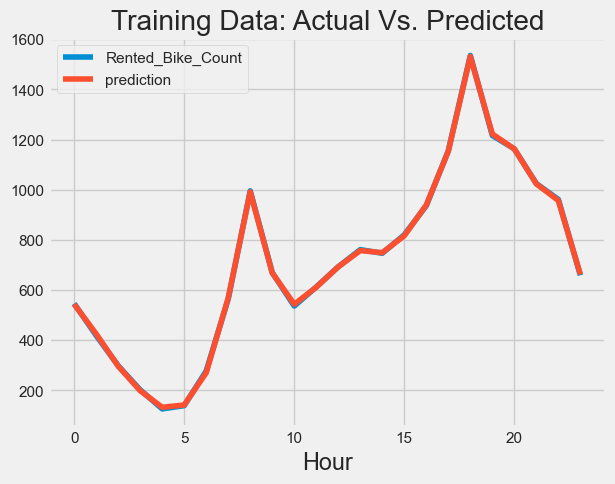

In [75]:
train_df = (pred_train.select("Rented_Bike_Count", "prediction", "Hour")).toPandas()
train_df.groupby('Hour').agg({'Rented_Bike_Count':'mean', 'prediction':'mean'}).plot()
plt.title('Training Data: Actual Vs. Predicted')
plt.show()

### Predictions Vs. Actual on Test Data

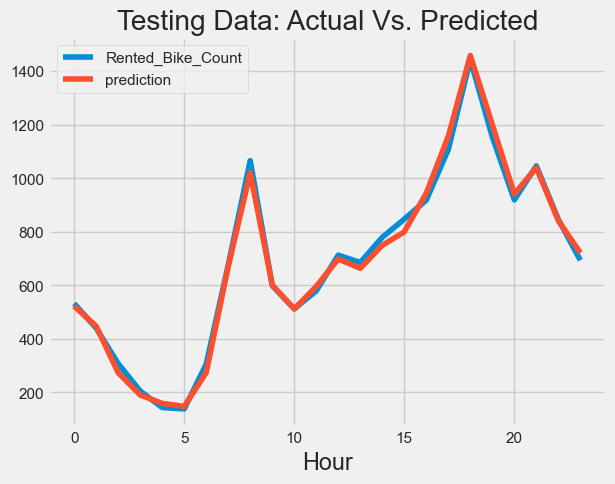

In [76]:
test_df = (pred_test.select("Rented_Bike_Count", "prediction", "Hour")).toPandas()
test_df.groupby('Hour').agg({'Rented_Bike_Count':'mean', 'prediction':'mean'}).plot()
plt.title('Testing Data: Actual Vs. Predicted')
plt.show()

### Model Evaluation Metrics

In [77]:
eval = RegressionEvaluator(labelCol = "Rented_Bike_Count", )
rmse = eval.evaluate(pred_train)
mse= eval.evaluate(pred_train, {eval.metricName: "mse"})
mae= eval.evaluate(pred_train, {eval.metricName: "mae"})
r2 = eval.evaluate(pred_train, {eval.metricName: "r2"})

print("RMSE     : %.3f" %rmse)
print("MSE      : %.3f" %mse)
print("MAE      : %.3f" %mae)
print("R2 score : %.3f" %r2)

RMSE     : 132.116
MSE      : 17454.595
MAE      : 85.732
R2 score : 0.959


In [78]:
eval = RegressionEvaluator(labelCol = "Rented_Bike_Count", )
rmse = eval.evaluate(pred_test)
mse= eval.evaluate(pred_test, {eval.metricName: "mse"})
mae= eval.evaluate(pred_test, {eval.metricName: "mae"})
r2 = eval.evaluate(pred_test, {eval.metricName: "r2"})

print("RMSE     : %.3f" %rmse)
print("MSE      : %.3f" %mse)
print("MAE      : %.3f" %mae)
print("R2 score : %.3f" %r2)

RMSE     : 249.377
MSE      : 62188.948
MAE      : 156.953
R2 score : 0.845


- The GBTRegressor model achieved a relatively low RMSE of 249.377, indicating that the predicted demand for rental bikes was, on average, about 249 bikes away from the actual demand. 
- The MSE was 62188.948, which is the average squared difference between the predicted and actual demand values. The MAE of 156.953 indicates that the predicted demand was, on average, about 156 bikes away from the actual demand.
- The R2 score of 0.845 indicates that the model explains 84.5% of the variance in the target variable, which is a relatively good performance. These metrics suggest that the GBTRegressor model has the potential to accurately predict the demand for rental bikes in the Capital Bike Share System.

### Interpreting Residuals
The residuals indicate the difference between the actual values in the validation data and the predicted values by the model. A positive residual is assigned to data points above the fitted line, and a negative residual to data points below the fitted line. A smaller residual value, closer to zero, implies a better fit between the model and the data.

The ideal residual plot, called the null residual plot, shows a random scatter of points forming an approximately constant width band around the identity line.
Visualising the scatter plot below , our model seems to be a best fit.

In [79]:
predictions_with_residuals = pred_test.withColumn("residual", (F.col("Rented_Bike_Count") - F.col("prediction")))
display(predictions_with_residuals.agg({'residual': 'mean'}))

DataFrame[avg(residual): double]

In [80]:
predictions_with_residuals.select("Hour", "residual").show(20)

+----+------------------+
|Hour|          residual|
+----+------------------+
|   0|59.455073746573674|
|   0| 92.15592470091826|
|   1|-22.18699414554429|
|   1|-27.25686240390631|
|   1| 67.88560292441676|
|   1| 79.67849587785024|
|   1|  126.210519767668|
|   2|-66.85234856791837|
|   2| 33.11195731255795|
|   2|-47.67284516323561|
|   2| 83.21545265768255|
|   3| 8.861228467558671|
|   3| 99.45478085595279|
|   3| 70.45254663217307|
|   3| 7.968907405455795|
|   3|-13.47996992759764|
|   3| 20.41936597152977|
|   3| 54.22543270088834|
|   3| 150.1591572060021|
|   3|-7.461626045184274|
+----+------------------+
only showing top 20 rows



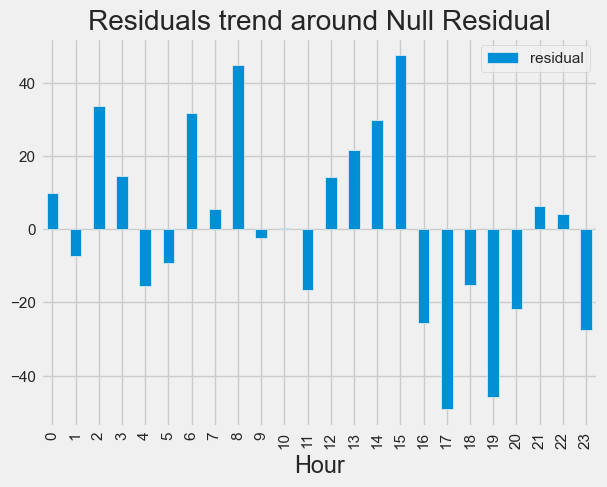

In [81]:
residuals_df = predictions_with_residuals.select("Hour", "residual").toPandas()
#residuals_df.plot(x= 'hr', y='residual', kind = 'bar')
residuals_df.groupby('Hour').agg({'residual':'mean'}).plot(kind='bar')
plt.title("Residuals trend around Null Residual")
plt.show()

In the given model, the RMSE for the training data is 132.116 and for the test data is 249.377. This suggests that on average, the model's predictions for the rental bike demand are off by around 132 and 249 bikes per hour for the training and test datasets, respectively.

The R2 score for the training data is 0.959, which indicates that 95.9% of the variance in the target variable can be explained by the predictor variables. The R2 score for the test data is 0.845, which suggests that the model explains around 84.5% of the variance in the target variable for the unseen data. Overall, the model appears to have a good fit, although there is a slight drop in performance when it comes to the test data.

##Inferences

-   We figured out our Best Model is **GBT Regressor**
+   On Train & Test data split of 65 - 35 we have the following **r2 score** 
    -   Train Data: r2 -> 0.959
    -   Test Data: r2 -> 0.845
-   MAE at 85.7 is also small for the breadth of data
-   The residuals across the hours of the day have no obvious correlations. 
-   The average residual is about 0.63, less than 1% of the average value of the Rented Bike Count column.

## Conclusion
- The best performing model on the Bike Sharing System dataset was the GBTRegressor with an R2 score of 0.959 on the training data and 0.845 on the test data. This model had a Root Mean Squared Error (RMSE) of 132.116 on the training data and 249.377 on the test data, which indicates that the model was able to predict the demand for rental bikes with reasonable accuracy. Additionally, the Mean Absolute Error (MAE) for the GBTRegressor on the test data was 156.953.
- Compared to the other three regression models that were tested, the GBTRegressor outperformed them with the highest R2 score. This implies that the model has captured most of the variability in the target variable, given the predictor variables.
- In addition to optimizing their inventory and logistics, the Capital Bike Share System can also use the model to improve their pricing strategies. The model can help them to identify the peak demand hours and the corresponding weather conditions that contribute to higher demand. Based on this information, the system can adjust their prices accordingly to maximize their profits.
- Furthermore, the model can be updated regularly to reflect changes in the weather patterns and other external factors that can impact the demand for rental bikes. By continuously improving the model, the Capital Bike Share System can stay ahead of the curve and provide better service to their customers.
- Overall, the high R2 score and low RMSE and MAE values for the GBTRegressor model indicate that the model has a good fit and performs well in predicting the demand for rental bikes. Therefore, the model can be considered reliable and can help the Capital Bike Share System to make data-driven decisions and improve their business operations.


## Scope for Improvements
-   There is a scope for improving the GBTRegressor model by increasing the amount of data to encompass more data points for holidays and extreme weather events. This can help the model to estimate demand more accurately on such adverse days. Additionally, deep learning models could be explored to better understand the causal information and predict demand more accurately.
- Furthermore, future weather information could be continuously fed into the model from meteorological data APIs to create an ML web app dashboard that projects the demand for rental bikes on an hourly basis. 
-  This can help the Capital Bike Share System to proactively manage their inventories and plan logistics based on predicted demand. Overall, there are several avenues for improvement, and incorporating these suggestions can further enhance the reliability and accuracy of the model.